# Perform Topic Modeling on Amazon Trends Data

Data Science Bootcamp - Rutgers University

Group 4: Team Members Tasnuva Airen, Will Giordano, Mostafa Moamen, Matthew Richtmyer

January 14, 2020

## Purpose:
* Explore most commonly discussed topics in Amazon Product Reviews. This allows us to conduct market research and identify key areas of opportunity (e.g. new product development, improved UI/UX, etc.)

# Import Clean Data
Using functions defined in Data_Exploration_and_Cleanup.ipynb

In [80]:
# %load functions.py
import pandas as pd

def cleanData():
    import pandas as pd

    """Docstring: clean data and aggregate all three datasources. Returns just one dataframe from all three csv files combined and cleaned"""

    ## Read Data ##
    data = "1429_1.csv"
    df = pd.read_csv(data)

    data1 = "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv"
    df1 = pd.read_csv(data1, header = 0)

    data2= "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv"
    df2 = pd.read_csv(data2, header = 0)

    ## STEP 1: Clean up first dataframe ##
    # drop extra columns
    df = df.drop(["asins", "keys","manufacturer", "reviews.didPurchase", "reviews.id", "reviews.sourceURLs", "reviews.userCity", "reviews.userProvince", "reviews.numHelpful" ], axis = 1)
    # rename columns to titles that make sense
    df.columns = ["ID", "Name", "Brand", "Category", "Review Date", "Date Added", "Date Seen", "Recommendation", "Rating", "Review", "Review Title", "Username"]
    df = df.drop("Date Added", axis = 1)

    ## STEP 2: Clean up second and third dataframe ##
    # These two dataframes have different number of columns

    # preallocate for new dataframe
    new_name = []

    # create column list
    cols = ['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
           'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
           'manufacturerNumber', 'reviews.date',
           'reviews.dateSeen', 'reviews.dateAdded', 'reviews.doRecommend', 'reviews.id',
           'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
           'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs']

    # Reorder columns so that they are consistent for both dataframes df1 and df2
    df1.columns = cols
    df2.columns = cols
    # concatenate df1 and df2 so they are stacked on top of eachother
    combined_data = pd.concat([df1, df2])

    # drop extra columns that don't provide useful information at this time (e.g. URLS)
    combined_data = combined_data.drop(["asins", "keys","manufacturer", "reviews.id", "imageURLs", "manufacturerNumber", "dateUpdated", "primaryCategories", "reviews.numHelpful", "sourceURLs", "reviews.sourceURLs" ], axis = 1)
    # rename columns to names that make sense. For example, remove review. structure
    combined_data.columns = ["ID","Date Added", "Name", "Brand", "Category", "Review Date" , "Date Seen","Date Added", "Recommendation", "Rating", "Review", "Review Title", "Username"]
    # reorder columns to flow better visually
    combined_data = combined_data[["ID", "Name", "Brand", "Category","Review Date", "Date Added", "Date Seen", "Recommendation", "Rating", "Review", "Review Title", "Username"]]
    # drop extra date column
    combined_data = combined_data.drop("Date Added", axis = 1)


    ## STEP 3: Combine all datasets ##
    # concatenate all dataframes
    full_data = pd.concat([df, combined_data])


    ## Step 4: Clean remaining data ##
    # drop extra date column
    full_data = full_data.drop("Date Seen", axis = 1)
    # reset index - since we concatenated three dataframes, there will be three '0' indices
    full_data = full_data.reset_index()
    # remove duplicate review texts
    full_data = full_data.drop_duplicates(subset='Review', keep='first')


    # -- Format Time -- ##
    # ensure consistent datatypes for rows in column
    full_data['Review Date'] = full_data['Review Date'].astype(str).str[0:10]
    # convert time object
    full_data['Review Date']=pd.to_datetime(full_data['Review Date'])
    # reformat time object
    full_data['Review Date'] = full_data['Review Date'].dt.strftime('%m/%d/%Y')

    # drop all nans
    full_data = full_data.dropna(how = "any", axis = 0)

    # -- Rename Product Names -- #
    # the product names are really long strings - >50 characters. Rename to simpler structure

    # split product name by commas and take first value
    new_name= full_data["Name"].str.split(",", n = 1, expand = True)
    full_data["Name"] = new_name[0]

    # rename a column
    full_data = full_data.rename(columns={"Name": "Product Name"})
    # rename all product names
    full_data["Product Name"]= full_data["Product Name"].replace({'Kindle Oasis E-reader with Leather Charging Cover - Merlot': 'Kindle Oasis E-reader with Leather Charging Cover', 'Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black': 'Amazon - Kindle Voyage', 'All-New Kindle Oasis E-reader - 7 High-Resolution Display (300 ppi)': 'All-New Kindle Oasis E-reader - 7', 'Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Black': 'Amazon - Kindle Voyage', "Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black":"Amazon Kindle Paperwhite",
                                                                  "Amazon 5W USB Official OEM Charger and Power Adapter for Fire Tablets and Kindle eReaders":"Amazon Charger for Fire and Kindle","Amazon - Amazon Tap Portable Bluetooth and Wi-Fi Speaker - Black":"Amazon Tap Bluetooth and Wi-Fi Speaker",
                                                                  "Amazon 9W PowerFast Official OEM USB Charger and Power Adapter for Fire Tablets and Kindle eReaders":"PowerFast USB Charger for Fire and Kindle","Amazon Fire Hd 8 8in Tablet 16gb Black B018szt3bk 6th Gen (2016) Android":"Amazon Fire Hd 8in Tablet Black Gen 6",
                                                                  "Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16":"Amazon Kindle Fire 7' Display Tablet", 'Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen': 'Amazon Echo with 7" Screen', 'Brand New Amazon Kindle Fire 16gb 7 Ips Display Tablet Wifi 16 Gb Blue' : 'Amazon Kindle Fire 7"'})

    return full_data                                                              


In [81]:
full_data = cleanData()

## Explore Sklearn Implementation

In [82]:
# import numpy stack

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [85]:
# import CountVectorizer - this performs Term Frequency - Inverse Term Frequency to vectorize words in all reviews
from sklearn.feature_extraction.text import CountVectorizer

# remove words that occur in more than 95% of documents. Remove words that occur less than 2 documents 
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")

# calculate document term matrix
dtm = cv.fit_transform(full_data["Review"])
dtm # should be a sparse matrix

<30645x6720 sparse matrix of type '<class 'numpy.int64'>'
	with 379012 stored elements in Compressed Sparse Row format>

In [86]:
# Sklearn - numpy stack machine learning library. import LDA model
from sklearn.decomposition import LatentDirichletAllocation

# instantiate model
LDA = LatentDirichletAllocation(n_components=10, random_state=42)

# fit the model
LDA.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

### Explore Visualizations 
One example is to plot word clouds of top ten words in each cluster

Top 15 words per topic #0
['card', 'highly', 'does', 'kindle', 'memory', 'tablet', 'amazon', 'price', 'money', 'recommend', 'good', 'best', 'product', 'great', 'buy']


Top 15 words per topic #1
['bought', 'internet', 'read', 'used', 'amazon', 'app', 'download', 'set', 'able', 'play', 'apps', 'books', 'easy', 'games', 'use']


Top 15 words per topic #2
['screen', 'life', 'easy', 'paperwhite', 'great', 'like', 'battery', 'book', 'reader', 'love', 'light', 'books', 'reading', 'read', 'kindle']


Top 15 words per topic #3
['nice', 'perfect', 'user', 'recommend', 'product', 'friendly', 'size', 'set', 'good', 'kids', 'love', 'tablet', 'great', 'use', 'easy']


Top 15 words per topic #4
['time', 'got', 'purchased', 'play', 'great', 'son', 'daughter', 'games', 'kids', 'love', 'tablet', 'bought', 'loves', 'year', 'old']


Top 15 words per topic #5
['little', 'value', 'need', 'perfect', 'just', 'beat', 'quality', 'does', 'product', 'amazon', 'works', 'good', 'price', 'tablet', 'great']


Top 15

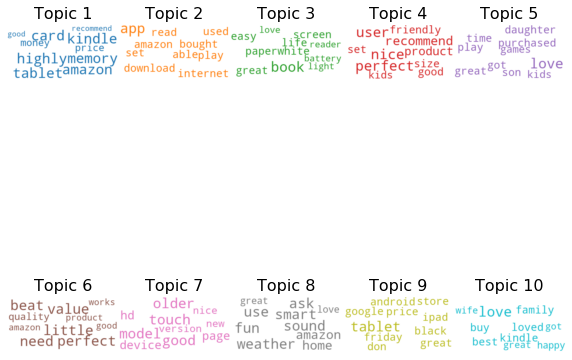

In [107]:
# create word clouds
from wordcloud import WordCloud
import matplotlib.colors as mcolors # choosing this color set because it looks nice

# import tableau colors because they are pretty
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

## Step 1: Preallocate vectors, figure subplots, etc. ##
# create figure and axes for subplots
fig, axes = plt.subplots(2, 5, figsize=(10,10), sharex=True, sharey=True)

# preallocate strings for word clouds
cloud_str = []


## Step 2: enumerate through all topics to see top 15 words. Use argsort to grab 15 largest terms
for index, topic in enumerate(LDA.components_):
    # get top 15 words per topic 
    print(f"Top 15 words per topic #{index}")
    # use arg sort to pick max 15
    features = [cv.get_feature_names()[i] for i in topic.argsort()[-15:]]
    
    # print output
    print(features)
    print("\n")
    
    # preallocate empty string to convert list of strings into one long string for the word cloud figs
    str1 = ""
    
    for element in features:
        str1+= element
        str1+= " "
    # save as list of strings to be used in word cloud
    cloud_str.append(str1)
    

## Step 3: Create word clouds! ##
# Create word clouds
for i, ax in enumerate(axes.flatten()):
    # add subplot figure
    fig.add_subplot(ax)
    
    # create word cloud - all of these parameters are fine tuning the visualization
    wordcloud = WordCloud(max_font_size=50, 
                          background_color="white",
                          #width=2500,
                          #height=1800,
                          colormap="tab10", 
                          max_words=10,
                          color_func=lambda *args, 
                          **kwargs: cols[i], 
                          prefer_horizontal=1.0).generate(cloud_str[i])

    
    # show word cloud, plot title and remove axis
    plt.gca().imshow(wordcloud, interpolation="bilinear")
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)

In [110]:
# LDA is unsupervised learning - take a crack at what these 10 topics could be. create mapping dictionary and 
# map back to original dataframe to see trends of categories, products, etc. within an LDA cluster

# transform current data
topic_results = LDA.transform(dtm)

# come back and fill this out after we analyze clusters
topics_dict = {0:"Kindle Tablets", 1:"Online Services", 2:"Kindle Paperwhite", 3:"UX", 4:"Family", 5:"Quality", 6:"Use Case", 7:"Use Case", 8:"Holiday Shopping", 9:"Family"}
full_data["Topics"] = topic_results.argmax(axis=1)
# create mapping to have topic title corresponding to each cluster #
full_data["Topic Title"] = full_data["Topics"].map(topics_dict)


In [112]:
# topics are added to original dataframe. Can now look at distribution of products per cluster
full_data.head()

,index,ID,Product Name,Brand,Category,Review Date,Recommendation,Rating,Review,Review Title,Username,Topics,Topic Title
0,0,AVqkIhwDv8e3D1O-lebb,All-New Fire HD 8 Tablet,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",01/13/2017,True,5.0,This product so far has not disappointed. My c...,Kindle,Adapter,3,UX
1,1,AVqkIhwDv8e3D1O-lebb,All-New Fire HD 8 Tablet,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",01/13/2017,True,5.0,great for beginner or experienced person. Boug...,very fast,truman,9,Family
2,2,AVqkIhwDv8e3D1O-lebb,All-New Fire HD 8 Tablet,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",01/13/2017,True,5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,DaveZ,3,UX
3,3,AVqkIhwDv8e3D1O-lebb,All-New Fire HD 8 Tablet,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",01/13/2017,True,4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,Shacks,6,Use Case
4,4,AVqkIhwDv8e3D1O-lebb,All-New Fire HD 8 Tablet,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",01/12/2017,True,5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,explore42,8,Holiday Shopping


In [113]:
# pull one specific cluster
# could perform more topic modeling to get granular subgroupings of this type of consumer
paperwhite = full_data.loc[ full_data["Topic Title"] == "Kindle Paperwhite",:]
paperwhite.head()

,index,ID,Product Name,Brand,Category,Review Date,Recommendation,Rating,Review,Review Title,Username,Topics,Topic Title
8,8,AVqkIhwDv8e3D1O-lebb,All-New Fire HD 8 Tablet,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",01/23/2017,True,5.0,Great as a device to read books. I like that i...,Great for reading,Weebee,2,Kindle Paperwhite
9,9,AVqkIhwDv8e3D1O-lebb,All-New Fire HD 8 Tablet,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",01/23/2017,True,5.0,I love ordering books and reading them with th...,Great and lightweight reader,RoboBob,2,Kindle Paperwhite
21,21,AVqkIhwDv8e3D1O-lebb,All-New Fire HD 8 Tablet,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",01/24/2017,True,5.0,Preloaded with the reading app from Kindle but...,Best Tablet Choice,jim9311,2,Kindle Paperwhite
26,26,AVqkIhwDv8e3D1O-lebb,All-New Fire HD 8 Tablet,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",01/27/2017,True,4.0,Perfect for downloading and reading books !! P...,"Great, quality tablet",Dave,2,Kindle Paperwhite
49,49,AVqkIhwDv8e3D1O-lebb,All-New Fire HD 8 Tablet,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",03/20/2017,True,5.0,this is my first tablet .. love it .. actually...,Awesome,grannybear,2,Kindle Paperwhite


In [118]:
# this is the product distribution within the Kindle Paperwhite cluster
gb = paperwhite.groupby("Product Name").count().sort_values(by="index",ascending=False)
gb

,index,ID,Brand,Category,Review Date,Recommendation,Rating,Review,Review Title,Username,Topics,Topic Title
Product Name,,,,,,,,,,,,
Amazon Kindle Paperwhite,1835,1835,1835,1835,1835,1835,1835,1835,1835,1835,1835,1835
Fire Tablet,654,654,654,654,654,654,654,654,654,654,654,654
Kindle Voyage E-reader,299,299,299,299,299,299,299,299,299,299,299,299
All-New Fire HD 8 Tablet,204,204,204,204,204,204,204,204,204,204,204,204
"Amazon Kindle Fire 7""",88,88,88,88,88,88,88,88,88,88,88,88
Amazon Fire Hd 8in Tablet Black Gen 6,74,74,74,74,74,74,74,74,74,74,74,74
All-New Fire HD 8 Tablet with Alexa,48,48,48,48,48,48,48,48,48,48,48,48
Kindle E-reader - White,43,43,43,43,43,43,43,43,43,43,43,43
Fire Kids Edition Tablet,37,37,37,37,37,37,37,37,37,37,37,37


Text(0.5, 0, 'Number of Reviews')

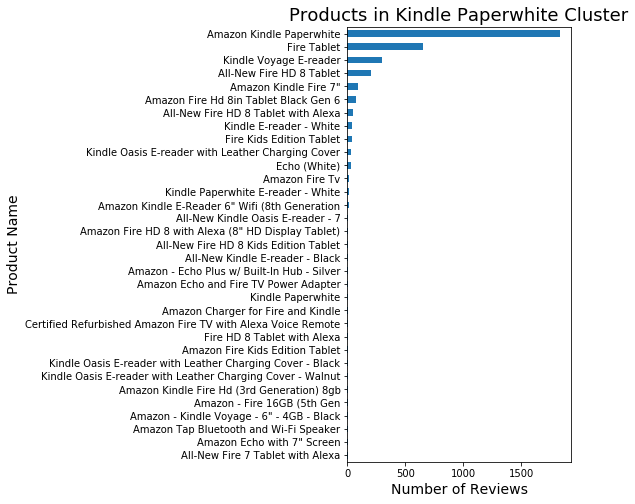

In [145]:
gb = paperwhite.groupby("Product Name").count().sort_values(by="index",ascending=True)
gb = gb["index"]
gb.plot(kind="barh", figsize=(4,8))
plt.title("Products in Kindle Paperwhite Cluster",fontsize=18)
plt.ylabel("Product Name", fontsize=14)
plt.xlabel("Number of Reviews",fontsize=14)

This demo code shows that we can perform topic modelling on the ~30k product reviews from Amazon products. We can then map that segmentation back to the original dataframe with corresponding rows having their predicted cluster. Above, we looked at the product distribution of one cluster and saw that it is dominated by the Amazon Fire Paperwhite SKU. Therefore, this cluster is most likely representing the target consumer for the Amazon Paperwhite Kindle product. 

We could repeat this for any other cluster as well. This cluster was chosen to demonstrate the concept. 

# Gensim Implementation

## It is important to note, these are seperate LDA models trained on the same data. 
We decided to explore different NLP packages and visualizations, so we can expect similar results, but the training will not be exactly the same because of random distributions of the training set

In [1]:
## References:
# Learning code new package from this website and adapting for our purposes
# https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [4]:
# Imports


## System, Regex operations, and Numpy Stack
import sys

import re, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

## Natural Language Processing Libraries
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

# supress warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthewrichtmyer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# import data - use cleanData function for all data cleaning

In [73]:
full_data = cleanData()

## Pre-processing: Clean text signal
Text signal is inherently messy and non ordered. Perform cleaning operations to improve signal and run time. 

Processes explored:
* Regular expressions - fancy simplification of characters in strings that are erroneous to model comprehension (e.g. @, +, etc.)
* Tokenization - break a sentence (long string) into list of individual words (e.g. one word string)
* Lemmatization - remove conjugations (e.g. codes, coding, coded, code all point to same word)



In [10]:
# convert review data to list
reviews = full_data["Review"].tolist()
reviews[0]

'This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.'

In [11]:
# write function to help clean up text
# clean up operations: lowercase, tokenize, remove special characters
def sent_to_words(sentences):
    for sent in sentences:
        # regex operations for cleaning string data in reviews
        
        # substitute all special characters
        # remove emails
        sent = re.sub('\S*@\S*\s?', '', sent)
        # remove new line characters
        sent = re.sub('\s+', ' ', sent)
        # remove quotes
        sent = re.sub("\'", "", sent)
        # change to lower case
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Data structure is a list of lists
data_words = list(sent_to_words(reviews))
print(data_words[:1])

[['this', 'product', 'so', 'far', 'has', 'not', 'disappointed', 'my', 'children', 'love', 'to', 'use', 'it', 'and', 'like', 'the', 'ability', 'to', 'monitor', 'control', 'what', 'content', 'they', 'see', 'with', 'ease']]


## Implement language model
* Load english model from Spacy - this is pretrained model with basic semantic understanding of the english language
* Load bigram model from Gensim - this is one of the simplist sequential models in NLP, which allows for the model to detect more accurate text. 

In [12]:
## load english language model

# run this to download the english model package:
# python -m spacy download en_core_web_sm
# documentation: https://spacy.io/usage/models

import en_core_web_sm
nlp = en_core_web_sm.load()

In [13]:
# build bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [14]:
# function to instantiate bigram model, and perform lemmatization
# this takes some time
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[w for w in simple_preprocess(str(doc)) if w not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts_out = []
    nlp = en_core_web_sm.load()
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        # filter out words that don't match the grammer rules we applied (i.e. are nouns, adjectives, etc)
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [15]:
# list of list - cleaned, lemmatized words in each review
# preview first review
data_ready[:1]

[['product',
  'far',
  'disappointed',
  'child',
  'love',
  'ability',
  'monitor',
  'control',
  'content',
  'ease']]

In [18]:
## this cell takes some time ##

# Create LDA Model
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
# model documentation for all hyperparameters
    # https://radimrehurek.com/gensim/models/ldamodel.html
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.145*"great" + 0.092*"light" + 0.066*"sound" + 0.061*"purchase" + '
  '0.045*"love" + 0.045*"buy" + 0.033*"speaker" + 0.026*"price" + '
  '0.022*"recommend" + 0.018*"kid"'),
 (1,
  '0.067*"echo" + 0.061*"love" + 0.056*"work" + 0.056*"music" + 0.040*"buy" + '
  '0.037*"home" + 0.035*"play" + 0.027*"alexa" + 0.027*"much" + 0.024*"dot"'),
 (2,
  '0.078*"product" + 0.053*"smart" + 0.040*"turn" + 0.033*"really" + '
  '0.033*"control" + 0.028*"hub" + 0.027*"able" + 0.019*"screen" + '
  '0.017*"bulb" + 0.017*"look"'),
 (3,
  '0.059*"well" + 0.048*"love" + 0.039*"ask" + 0.038*"alexa" + 0.035*"gift" + '
  '0.034*"feature" + 0.032*"enjoy" + 0.030*"question" + 0.028*"house" + '
  '0.025*"item"'),
 (4,
  '0.050*"device" + 0.046*"set" + 0.044*"show" + 0.035*"thing" + 0.028*"time" '
  '+ 0.020*"read" + 0.020*"room" + 0.019*"new" + 0.017*"echo" + '
  '0.016*"weather"')]


These weights make up the model. When a new review comes in, the model is testing for a specific word distribution with these weights if the product is large enough, the model predicts that the new review belongs to a particular class

In [19]:
## this cell takes some time

# import visualization packages and enable them to work in jupyter environment
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# create cluster visual with PC axes
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/matthewrichtmyer/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.217594 -0.307654       1        1  23.598179
1     -0.205064  0.020340       2        1  22.740726
0     -0.122318  0.160717       3        1  21.356895
2      0.291338  0.240558       4        1  17.349321
3     -0.181550 -0.113961       5        1  14.954883, topic_info=     Category         Freq        Term        Total  loglift  logprob
13    Default  9976.000000       great  9976.000000  30.0000  30.0000
92    Default  6342.000000       light  6342.000000  29.0000  29.0000
9     Default  4343.000000     product  4343.000000  28.0000  28.0000
345   Default  4538.000000       sound  4538.000000  27.0000  27.0000
88    Default  4198.000000    purchase  4198.000000  26.0000  26.0000
132   Default  4112.000000        work  4112.000000  25.0000  25.0000
161   Default  4095.000000       music  4095.000000  24.0000  24.0000
104   Default  3814.000000      device  3814.000000  23.0000  23.0000
298   Default  2864.000000        well  2864.000000  22.0000  22.0000
7     Default  9888.000000        love  9888.000000  21.0000  21.0000
2103  Default  2941.000000       smart  2941.000000  20.0000  20.0000
76    Default  3491.000000         set  3491.000000  19.0000  19.0000
10    Default  5999.000000         buy  5999.000000  18.0000  18.0000
276   Default  3370.000000        show  3370.000000  17.0000  17.0000
470   Default  2682.000000        home  2682.000000  16.0000  16.0000
660   Default  3785.000000       alexa  3785.000000  15.0000  15.0000
824   Default  2247.000000        turn  2247.000000  14.0000  14.0000
193   Default  2673.000000       thing  2673.000000  13.0000  13.0000
129   Default  2526.000000        play  2526.000000  12.0000  12.0000
750   Default  1863.000000         ask  1863.000000  11.0000  11.0000
650   Default  2262.000000     speaker  2262.000000  10.0000  10.0000
49    Default  1851.000000      really  1851.000000   9.0000   9.0000
12    Default  1703.000000        gift  1703.000000   8.0000   8.0000
3     Default  1828.000000     control  1828.000000   7.0000   7.0000
98    Default  1614.000000     feature  1614.000000   6.0000   6.0000
116   Default  2116.000000        time  2116.000000   5.0000   5.0000
224   Default  1554.000000       enjoy  1554.000000   4.0000   4.0000
160   Default  1954.000000        much  1954.000000   3.0000   3.0000
1225  Default  1454.000000    question  1454.000000   2.0000   2.0000
75    Default  1762.000000       price  1762.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
98     Topic5  1613.946289     feature  1614.779541   1.8996  -3.3954
224    Topic5  1553.962158       enjoy  1554.795776   1.8996  -3.4333
1225   Topic5  1453.982056    question  1454.809937   1.8996  -3.4998
1428   Topic5  1350.390625       house  1351.234253   1.8995  -3.5737
547    Topic5  1182.491943        item  1183.325439   1.8994  -3.7065
295    Topic5   938.260864        find   939.093201   1.8992  -3.9379
770    Topic5   905.989746        tell   906.831726   1.8992  -3.9729
262    Topic5   844.491882        wife   845.321411   1.8992  -4.0431
1092   Topic5   803.029114      answer   803.856018   1.8991  -4.0935
542    Topic5   795.220703      system   796.065125   1.8991  -4.1033
69     Topic5   769.642029        give   770.470581   1.8991  -4.1360
195    Topic5   632.060791         son   632.883972   1.8988  -4.3329
153    Topic5   623.387756       whole   624.224121   1.8988  -4.3467
441    Topic5   562.869995          tv   563.706177   1.8986  -4.4488
642    Topic5   556.785095  absolutely   557.612671   1.8986  -4.4597
172    Topic5   517.441589       small   518.279114   1.8985  -4.5330
498    Topic5   497.712433   different   498.542725   1.8985  -4.5719
261    Topic5   479.660492        keep   480.498627   1.8984  -4.6088
790    Topic5   474.567322      decide   475.407837   1.8984  -4.6195
207    To

In [147]:
pyLDAvis.save_html(vis,"Results/LDA-vis.html")

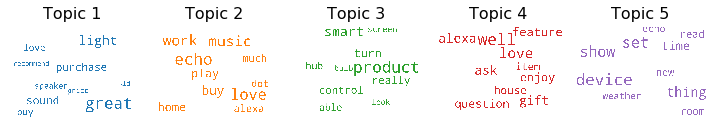

In [62]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# word cloud parameters: see documentation
# https://github.com/amueller/word_cloud
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

# display all topics
topics = lda_model.show_topics(formatted=False)

# create figure and axes for plotting word clouds. Share x and y axis across all subplots
fig, axes = plt.subplots(1, 5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    # pull words from ith topic
    topic_words = dict(topics[i][1])
    # generate word cloud
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    # plot word cloud and format titles, axis, etc. 
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

# final plot formatting
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig("Results/word-clouds.png")
plt.show()

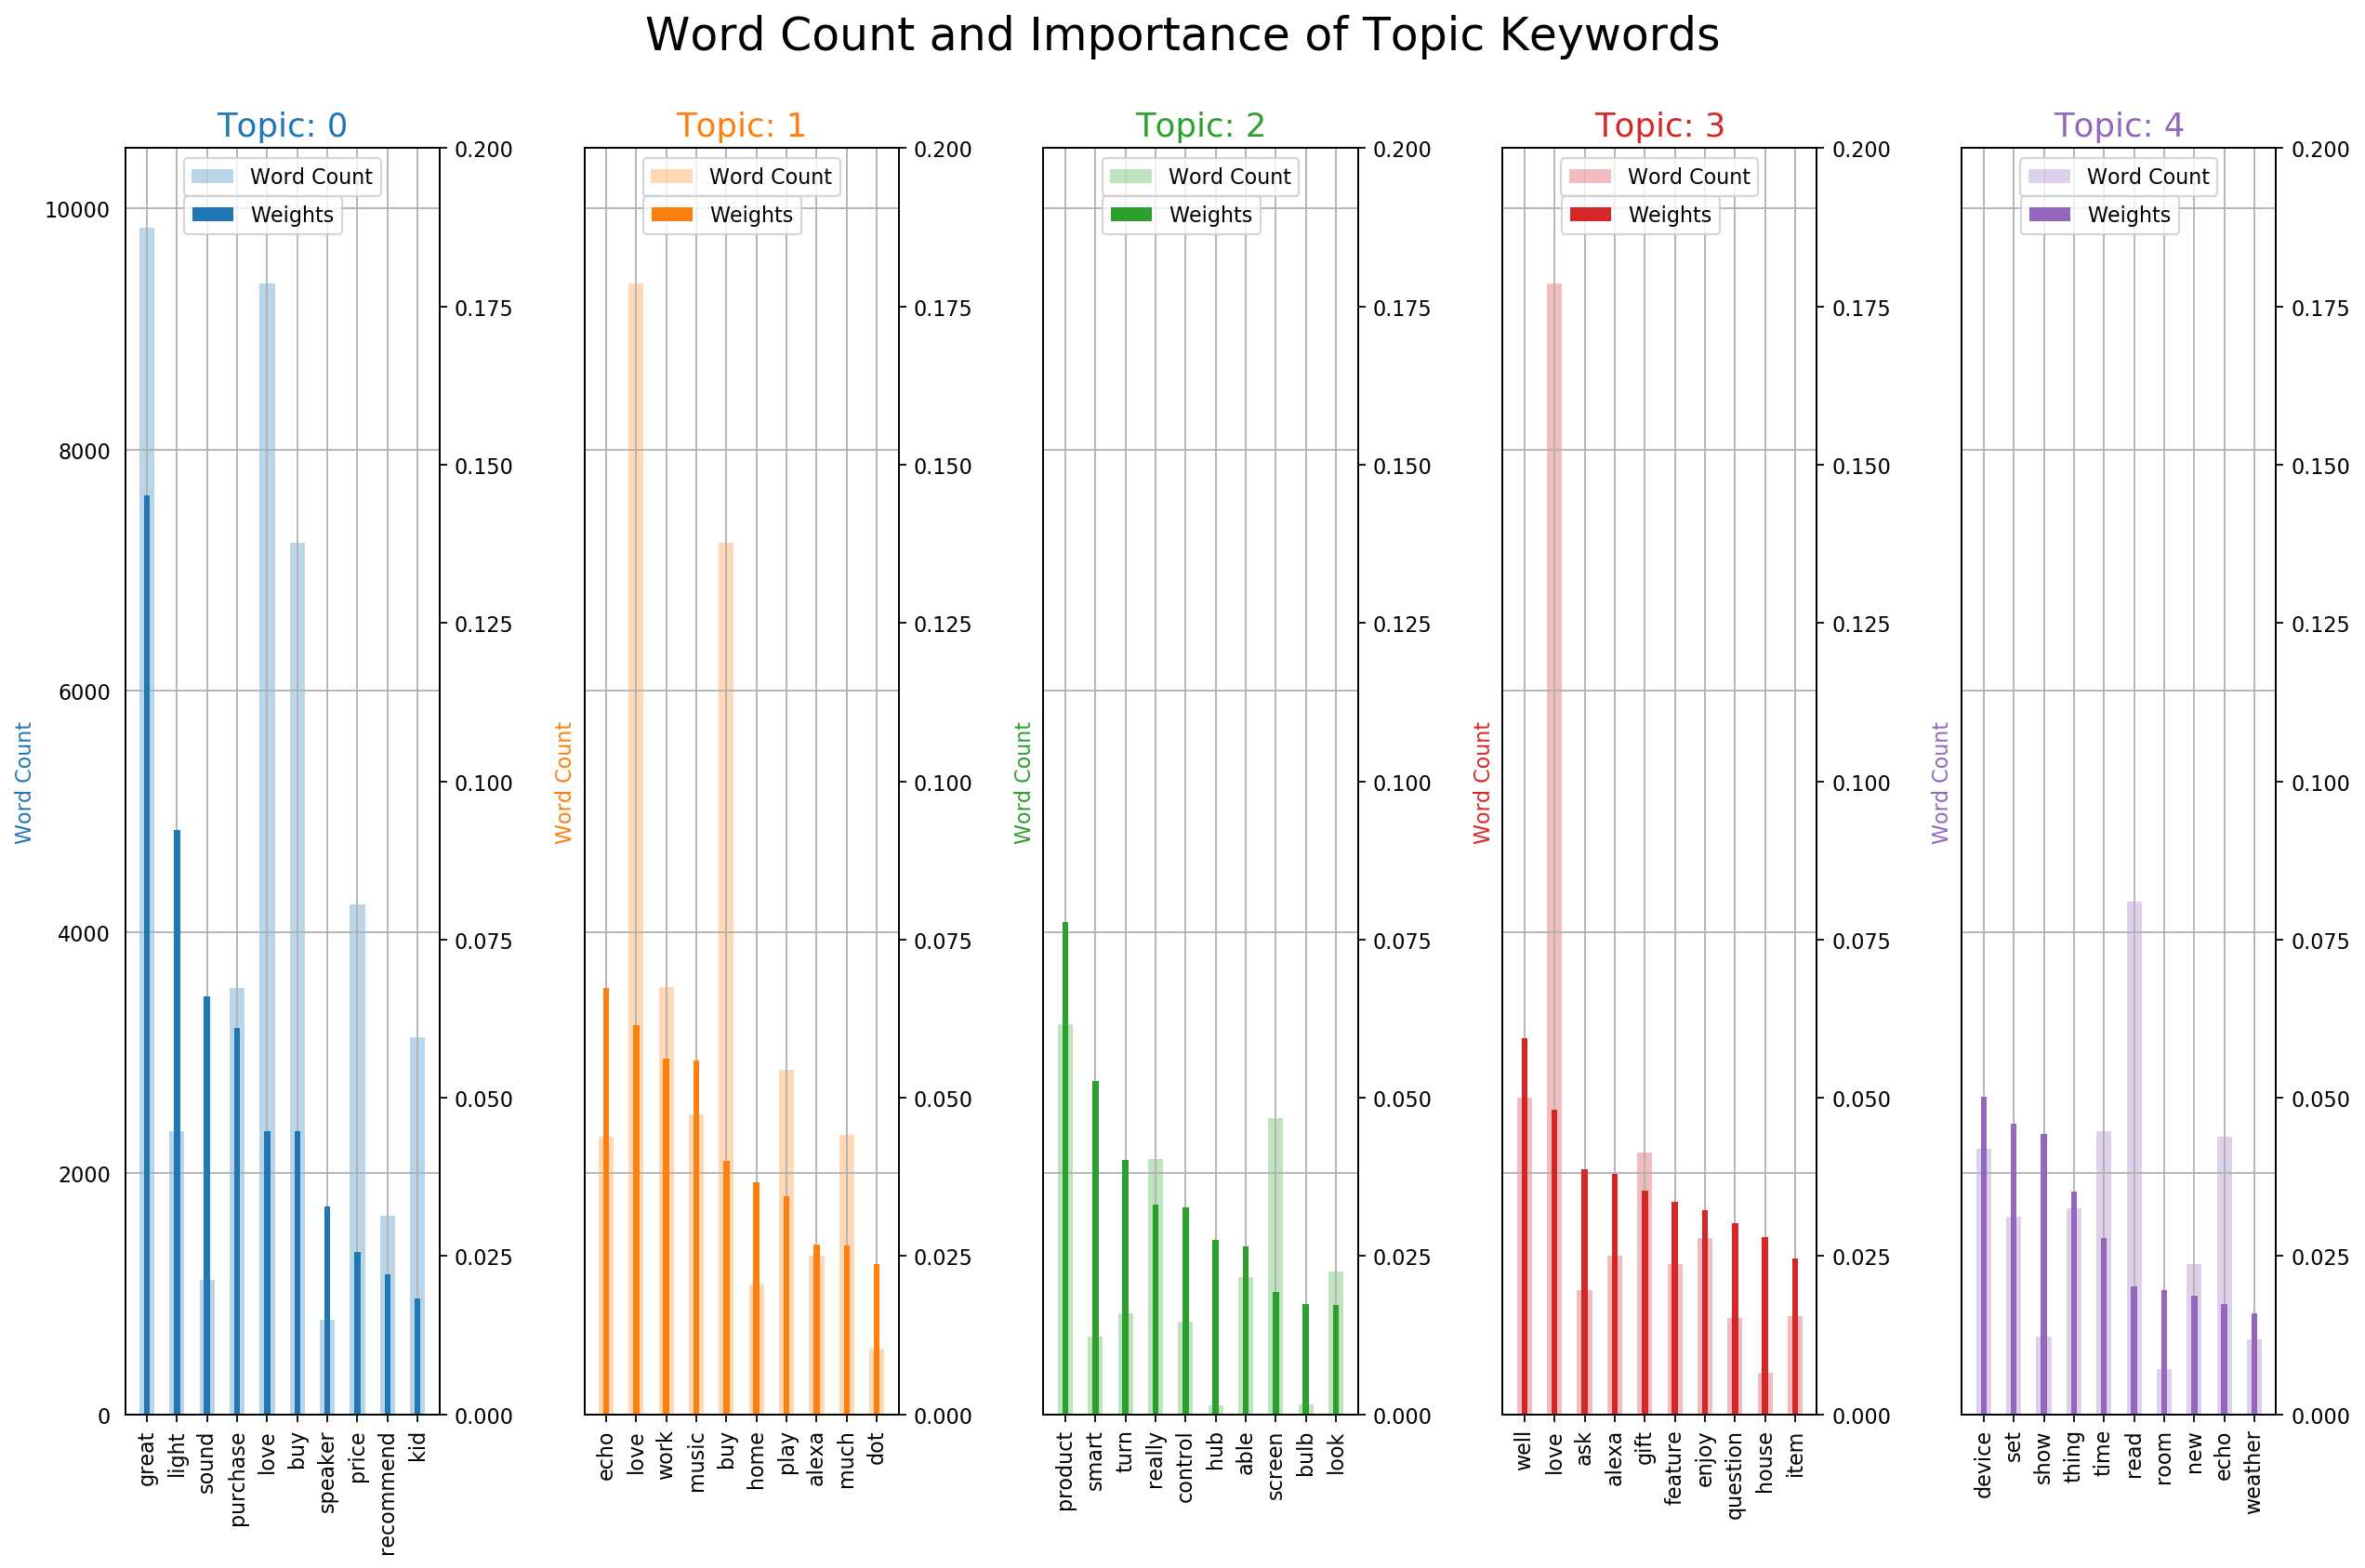

In [61]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, 5, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    # plot word count distribution with respective frequencies. 
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx() # create second axis on each ax
    # plot weights corresponding to each word on second axis
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    
    ## graph formatting ##
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.2); ax.set_ylim(0, 10500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=90, horizontalalignment= 'center')
    #ax.legend(loc=9, bbox_to_anchor=(0.5, -0.15)); ax_twin.legend(loc=9, bbox_to_anchor=(0.44, -0.19))
    ax.legend(loc=9, bbox_to_anchor=(0.5, 1)); ax_twin.legend(loc=9, bbox_to_anchor=(0.44, 0.97))
    ax.grid()
    
    

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)  
plt.savefig("Results/word-count_vs_weight.png")
plt.show()